# 数据分析与实践实验三-实验报告

*刘眭怿 PB20061256 2023.5.3*

## 实验要求
> PISA2018包含了学生问卷，考试诊断，学校、老师等数个数据集。本次实验针对PICA2015中的学生调查问卷数据集，共490个特征。
> - 预测目标：学生是否复读(repeat grade);
> - 指出哪些相关特征可以用来分析和预测；又可以抽取和构造哪些特征；
> - 指出哪些特征是强相关的，哪些不是；
> - 自由探索特征之间的相关性；
> - 使用可视化工具表现这些特征的关系。

## 实验分析

1. 首先对数据字段的概况进行了解，根据常识和经验，以及字段的含义，进行初步的筛选；
2. 对数据集进行预处理，删去显著异常的数据；剔除重复字段或者无效字段（考虑到是原始数据集的部分截取，故存在部分字段重复）；
3. 从数据集中筛选出部分关键的概况性字段，进行数据整体的刻画和分析；
4. 然后根据常识，和上一步得到的一些初步结论，依次对细节性的具体字段经行测试和预测，判断与目标字段的相关性；其中可能需要使用不同的算法模型；
5. 提取出关键特征后，进一步分析其相关性，并给出可能的现实意义的解释；绘制图表表现这些关系。

## 实验过程

### 各项特征的概况

- 通过codebook得到数据表格中的字段最基本的概况，字段大致可以分为以下几种：
  - **学生的基本概况信息**；
  - 具体的问卷调查的问题回答；
  - 具体的考试测试的问题得分；
  - 问卷、报告的语言设置等；
  - **学生父母的概况信息**；
  - 学生日常的语言使用情况；
  - 学生日常对于电子通讯设备(ICT)的使用情况；
  - **学生原生家庭概况**；
  - **学生就读的学校变动次数**；
  - 学习各类科目使用的时间；
  - 由问卷和考试得到的对于学生的各类信息的加权似然估计(WLE)
- 由字段的性质，删去原始数据集中的无效字段：
  - 重复字段，例如国家编号`CNTRYID`和国籍`CNT`可以视为同一个字段，年龄`AGE`和出生日期`ST001D02T`可视为同一个字段，所在年级`ST001D01T`和理应所在年级差值`GRADE`可视为一个字段；
  - 由常识和先验知识，删去一些基本可以确定的无关字段，例如`LANGTEST_COG`问卷的语言类型，后续可以验证，该字段数值与国籍高度重复；
- 由常识和先验知识，找出刻画学生的概况的字段，例如国籍，年龄，年级（国际标准化）等，用于对数据概况的分析，后续再加入具体问卷问题的字段数据；
- 由特征的涵义可知，一个与`REPEAT`高度相关的字段是`GRADE`，表示该学生当前年级与该国的此年纪的学生理应所在年级的差值；
- 打开原始数据集，进行预处理；
  - 注意到其中有一个数据的誊写位置发生了错位，舍去该数据，数据集的大小可以由75M缩小到35M，减小内存开销；\*  
  - 此时的数据共有27166条；
  - 按国籍划分，共计3个国家的学生数据； 
  - 按照是否复读划分，共计3种类型，其中无复读的数据共为20601条，复读数据共6546个，缺失数据共19个。
  - 删去重复字段,由于国籍总共3种，因此`OCED`字段也可视为是重复的；
  - 删去无区分度的字段，例如`ADMINMODE`的数值均为2；
- 得到预处理的数据集，命名为`lab3-data-pre.csv`\*\*
- 根据常识，对特征进行先验性的假设：一个学生如果留级，则可能的原因有
  - 学习成绩不理想；
  - 身体原因，休学留级；
  - 家庭变故，休学留级；
  - 转校留级；

\*该数据条目的各字段数据均明显错误，故舍去
| |	index|	CNTRYID| 	CNT|
| --|-- | --|-- |	
|111|	27167|	71829|	724|	

\*\* 可以直接打开`lab3-data.csv`，对于`CNT`字段进行筛查，便能找到异常样本，直接剔除即可;

此时的读入数据操作的代码为：
```
dataset=pd.read_csv("./lab3-data.csv")
dataset.loc[dataset['CNT']=='724']
......
```
之所以预先在Excel中处理是为了后续ipynb中打开时减少内存开销，否则绘图时，耗时可能超过20s的默认单模块运算时间上限。

### 对描述学生概况的特征进行分析

- 打开juputer notebook，进行基本的前置工作，包括：
  - 导入基本的库函数；
  - 导入原始数据；
  - 了解数据集概况；
  - 划分为训练，测试，预测集合（即`repeat`字段缺失的数据）；

In [108]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import os,sys

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#change the workspace file path
os.chdir(sys.path[0])
#columns for a overall view upon dataset; 'ST004D01T' is GENDER
overview_columns=['CNT','ST004D01T','GRADE','AGE','IMMIG','REPEAT']
#preset feature combinations for testment
academic_columns=['MMINS','LMINS','SMINS','TMINS','UNDREM','METASUM','METASPAM','AGE','REPEAT']
school_change_columns=['DURECEC','SCCHANGE','CHANGE','IMMIG','REPEAT']  
family_columns=['ESCS','HOMEPOS','CULTPOSS','HEDRES','WEALTH','ICTRES','REPEAT']#abolished
health_columns=['STUBMI','ST004D01T','REPEAT']#abolished

dataset_overview=pd.read_csv("./lab3-data-pre.csv",usecols=overview_columns)
#switch datatype to Int64, including NaN
int64_columns=['ST004D01T','GRADE','REPEAT','IMMIG',]
for col in int64_columns:
    #a weird thing is that 'int64' cannot support NaN, but 'Int64' can.
    dataset_overview[col]=dataset_overview[col].astype('Int64')

print(dataset_overview.columns.values)

['CNT' 'ST004D01T' 'GRADE' 'AGE' 'IMMIG' 'REPEAT']


为了对概况进行了解，我们大胆舍去所有概况性特征存在缺失的样本。可以看到，缺失的样本数量不多，对后续的结论影响不大。

In [109]:
dataset_overview.isna().sum()

CNT            0
ST004D01T      0
GRADE          0
AGE            0
IMMIG        232
REPEAT        19
dtype: int64

In [110]:
#data type now satisfies the following demand.
dataset_overview=dataset_overview.dropna(axis=0,how='any')
dataset_overview.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26921 entries, 0 to 27165
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CNT        26921 non-null  object 
 1   ST004D01T  26921 non-null  Int64  
 2   GRADE      26921 non-null  Int64  
 3   AGE        26921 non-null  float64
 4   IMMIG      26921 non-null  Int64  
 5   REPEAT     26921 non-null  Int64  
dtypes: Int64(4), float64(1), object(1)
memory usage: 1.5+ MB


选择的概况性的特征中：
- 连续的的有：年龄；（由于统计的出生日期仅精确到月份，因此该数值实际为离散，此处可视为连续）
- 离散的特征有：国籍，是否是移民，性别，理应所在年级，是否留级；
- 其中二值化的特征有：性别，是否留级。

接下来对概况性特征进行数量上的统计：

In [111]:
dataset_overview['CNT'].value_counts()

ESP    25785
PAN     1026
CHL      110
Name: CNT, dtype: int64

In [112]:
dataset_overview['ST004D01T'].value_counts()

1    13565
2    13356
Name: ST004D01T, dtype: Int64

In [113]:
dataset_overview['REPEAT'].value_counts()

0    20463
1     6458
Name: REPEAT, dtype: Int64

In [114]:
dataset_overview.describe(include=['float64'])

,AGE
count,26921.000000
mean,15.835580
std,0.287142
min,15.330000
25%,15.580000
50%,15.830000
75%,16.080000
max,16.330000


In [138]:
dataset_overview['GRADE'].value_counts()

 0    20225
-1     6635
 1       61
Name: GRADE, dtype: int64

In [116]:
#an easy glance upon 'GRADE' column and it shows great correlation with 'REPEAT'.
target_column='GRADE'
dataset_overview[[target_column, 'REPEAT']].groupby([target_column], as_index=False).mean().sort_values(by=target_column, ascending=True)

,GRADE,REPEAT
0,-3,0.869565
1,-2,0.933502
2,-1,0.928282
3,0,0.014487
4,1,0.016667
5,2,0.0


In [117]:
target_column='IMMIG'
dataset_overview[[target_column, 'REPEAT']].groupby([target_column], as_index=False).mean().sort_values(by=target_column, ascending=True)

,IMMIG,REPEAT
0,1,0.214194
1,2,0.417989
2,3,0.477689


我们做出假设：在根据学生理应所在年级`GRADE`进行划分后，寻找其余特征可以很好的对是否复读进行拟合。即一个简易的浅层决策树可以得出很好的预测结果。

由于所在年级的差值的+2,-3的数据点过少，因此可以将`GRADE`划分为三类，即`>0,=0,<0`，这样可以减少`IMMIG=3,GRADE=-3`的样本数量过少带来的估计误差。

同时，我们还看到，性别、国籍、移民类型对是否复读存在影响，但不大。

c:\Users\PDW\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\PDW\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:717: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


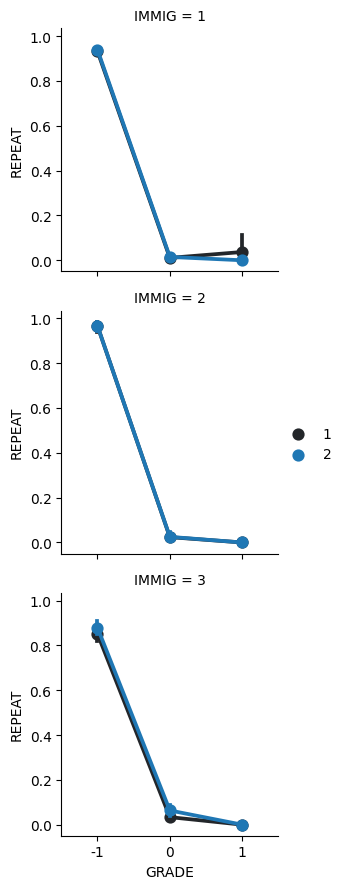

In [118]:
grade_map={-3:-1,-2:-1,-1:-1,0:0,1:1,2:1}
dataset_overview['GRADE']=dataset_overview['GRADE'].map(grade_map)
g = sns.FacetGrid(dataset_overview, row='IMMIG',)
g.map(sns.pointplot,'GRADE','REPEAT','ST004D01T')
g.add_legend()

单个特征`GRADE`对`REPEAT`的预测效果极佳，且进一步从概况性特征中提升f1-score的效果可能不明显。

In [119]:
y_pred=[int(x<0) for x in dataset_overview['GRADE']]
y_true=[int(x) for x in dataset_overview['REPEAT']]

from sklearn.metrics import f1_score
f1_score(y_true,y_pred,average='macro')

0.9613991827216236

从基本的数量统计上，我们可以看到：
- 大部分的学生正常升学，有24.1%的学生存在留级的情况；
- 这些学生的数据全部来自于三个国家，其中`ESP`的样本数量最多，占比达95.5%；由于其余两个国家的样本数量过少，导致我们无法推测否留级与国别是否有直接的强相关性； 
- 样本中的性别分布接近相等；
- 所有学生样本的年龄均介于15.33至16.33岁之间；
- `GRADE`和`REPEAT`特征高度相关，这是由特征的现实涵义决定的；
  - 如果学生所在年级高于期望的年级，则大概率属于跳级的情况；
  - 如果学生所在年级吻合于期望的年级，则属于正常情况；74.9%的学生样本均处于期望的年级中；
  - 如果学生所在年级低于期望的年级，则大概率属于留级的情况；
- 是否是移民、是第几代移民的特征`IMMIG`,对于复读的情况也有影响。
- 我们还可以看到，无直接强关联的特征有：性别，国籍，年龄。

接下来根据`GRADE`和其余信息，进一步提升对于`REPEAT`的预测准确度`F1-score`。

如果单纯利用概况性信息`overview_columns`，样本容量不足以支持第一个任务，即进一步细分特征的选取后，可能造成过拟合的情况。我们从先前的四个假设中重新审视其他特征对于`REPEAT`的关系性。

我们做出如下假设：学生的学习成绩不理想，学习能力无法满足正常升学的要求，因此留级。相关的特征可能有：
- 学生花费在各类科目的学习时间，包括`'MMINS','LMINS','SMINS','TMINS'`；
- 学生的各类抽象的学习能力，包括`'UNDREM','METASUM','METASPAM'`；

由于身体健康原因没有直接相关特征，仅身体BMI指数相关，故作罢。

In [120]:
dataset_academic=pd.read_csv("./lab3-data-pre.csv",usecols=academic_columns)
dataset_academic.isna().sum()

AGE            0
REPEAT        19
MMINS       4659
LMINS       4660
SMINS       4845
TMINS       8736
UNDREM       846
METASUM      868
METASPAM    1135
dtype: int64

In [121]:
time_columns=['MMINS','LMINS','SMINS','TMINS',]
for col in time_columns:
  dataset_academic[col].fillna(dataset_academic[col].dropna().median(), inplace=True)

In [122]:
dataset_academic=dataset_academic.dropna(axis=0,how='any')
dataset_academic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25207 entries, 0 to 27165
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AGE       25207 non-null  float64
 1   REPEAT    25207 non-null  float64
 2   MMINS     25207 non-null  float64
 3   LMINS     25207 non-null  float64
 4   SMINS     25207 non-null  float64
 5   TMINS     25207 non-null  float64
 6   UNDREM    25207 non-null  float64
 7   METASUM   25207 non-null  float64
 8   METASPAM  25207 non-null  float64
dtypes: float64(9)
memory usage: 1.9 MB


In [123]:
dataset_academic.describe(include=[float])

,AGE,REPEAT,MMINS,LMINS,SMINS,TMINS,UNDREM,METASUM,METASPAM
count,25207.000000,25207.000000,25207.000000,25207.000000,25207.000000,25207.000000,25207.000000,25207.000000,25207.000000
mean,15.835249,0.233903,231.187964,225.677391,200.942199,1689.007419,0.211331,0.253519,0.016207
std,0.287477,0.423320,89.319847,92.011098,137.615182,365.470989,0.919120,0.894271,0.966326
min,15.330000,0.000000,0.000000,0.000000,0.000000,110.000000,-1.640000,-1.720000,-1.410000
25%,15.580000,0.000000,200.000000,200.000000,150.000000,1650.000000,-0.600000,-0.180000,-0.500000
50%,15.830000,0.000000,220.000000,220.000000,165.000000,1650.000000,0.450000,0.590000,-0.040000
75%,16.080000,0.000000,220.000000,220.000000,240.000000,1760.000000,0.800000,0.980000,0.870000
max,16.330000,1.000000,2400.000000,2300.000000,2400.000000,3000.000000,1.500000,1.360000,1.330000


In [124]:
target_column='TMINS_BAND'
dataset_academic[target_column] = pd.cut(dataset_academic['TMINS'], 10)
dataset_academic[[target_column, 'REPEAT']].groupby([target_column], as_index=False).mean().sort_values(by=target_column, ascending=True)

,TMINS_BAND,REPEAT
0,"(107.11, 399.0]",0.660377
1,"(399.0, 688.0]",0.340265
2,"(688.0, 977.0]",0.316017
3,"(977.0, 1266.0]",0.262745
4,"(1266.0, 1555.0]",0.191085
5,"(1555.0, 1844.0]",0.233098
6,"(1844.0, 2133.0]",0.218837
7,"(2133.0, 2422.0]",0.248120
8,"(2422.0, 2711.0]",0.253918
9,"(2711.0, 3000.0]",0.273305


In [125]:
target_column='MMINS_BAND'
dataset_academic[target_column] = pd.cut(dataset_academic['MMINS'], 10)
dataset_academic[[target_column, 'REPEAT']].groupby([target_column], as_index=False).mean().sort_values(by=target_column, ascending=True)
dataset_academic=dataset_academic.drop([target_column],axis=1)
#Other time spent upon specific lessons holds the similar conclutions.

In [126]:
dataset_academic[['UNDREM', 'REPEAT']].groupby(['UNDREM'], as_index=False).mean().sort_values(by='UNDREM', ascending=True)
#Other MLE of students' personal academic capability holds the similar conclutions.

,UNDREM,REPEAT
0,-1.64,0.383120
1,-1.29,0.318542
2,-0.94,0.331301
3,-0.60,0.286980
4,-0.25,0.273323
5,0.10,0.218061
6,0.45,0.226740
7,0.80,0.180208
8,1.15,0.153538
9,1.50,0.146403


<AxesSubplot: xlabel='UNDREM', ylabel='TMINS_BAND'>

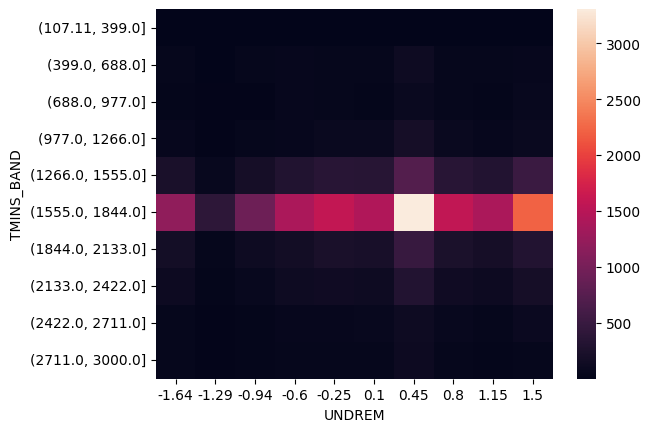

In [127]:
sns.heatmap(pd.crosstab(dataset_academic['TMINS_BAND'],dataset_academic['UNDREM']))

对于学习表现特征的一些统计结论：
- 具体学科的学习时间、总体学习时间符合方差较大的正态分布，这可能和统计口径有关，大部分样本的学习花费时间均落在特定的时间段内；
- 总体学习花费时间对于是否复读有较大的区分度，而具体学科的花费时间指示性较弱；
- 学习能力评估和学习时间花费相吻合，基本符合双变量正态分布；
- 具体的学生个人能力评估MLE对于是否复读的区分度较弱。

因此我们仅保留`TMINS_BAND`特征和个人能力评估的一个加权平均参考值`META`

In [128]:
dataset_academic=dataset_academic.drop(['MMINS','LMINS','SMINS','TMINS'],axis=1)
dataset_academic.head()

,AGE,REPEAT,UNDREM,METASUM,METASPAM,TMINS_BAND
0,15.83,0.0,0.45,-1.72,-1.41,"(1555.0, 1844.0]"
1,16.00,0.0,0.80,0.59,1.33,"(1555.0, 1844.0]"
2,15.42,0.0,1.50,0.59,-0.50,"(1555.0, 1844.0]"
3,16.25,0.0,1.50,1.36,0.42,"(2422.0, 2711.0]"
4,16.08,0.0,0.80,-0.18,0.42,"(1266.0, 1555.0]"


In [129]:
meta_columns=['UNDREM',	'METASUM',	'METASPAM']
for col in meta_columns:
    dataset_academic[col]=(dataset_academic[col]-dataset_academic[col].mean())/dataset_academic[col].std()

dataset_academic['META']=dataset_academic['UNDREM']+dataset_academic['METASUM']+dataset_academic['METASPAM']

for col in meta_columns:
    dataset_academic=dataset_academic.drop([col],axis=1)

dataset_academic.head()

,AGE,REPEAT,TMINS_BAND,META
0,15.83,0.0,"(1555.0, 1844.0]",-3.423081
1,16.00,0.0,"(1555.0, 1844.0]",2.376308
2,15.42,0.0,"(1555.0, 1844.0]",1.244136
3,16.25,0.0,"(2422.0, 2711.0]",3.057232
4,16.08,0.0,"(1266.0, 1555.0]",0.573561


In [130]:
target_column='META_BAND'
dataset_academic[target_column] = pd.cut(dataset_academic['META'], 10)
dataset_academic[[target_column, 'REPEAT']].groupby([target_column], as_index=False).mean().sort_values(by=target_column, ascending=True)

,META_BAND,REPEAT
0,"(-5.707, -4.727]",0.455724
1,"(-4.727, -3.758]",0.413876
2,"(-3.758, -2.788]",0.406618
3,"(-2.788, -1.819]",0.366618
4,"(-1.819, -0.849]",0.315640
5,"(-0.849, 0.121]",0.244686
6,"(0.121, 1.09]",0.197239
7,"(1.09, 2.06]",0.145814
8,"(2.06, 3.029]",0.119056
9,"(3.029, 3.999]",0.082606


In [131]:
dataset_academic=dataset_academic.drop(['META'],axis=1)
dataset_academic['AGE']=dataset_academic['AGE'].astype('category')
dataset_academic['REPEAT']=dataset_academic['REPEAT'].astype('category')
dataset_academic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25207 entries, 0 to 27165
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   AGE         25207 non-null  category
 1   REPEAT      25207 non-null  category
 2   TMINS_BAND  25207 non-null  category
 3   META_BAND   25207 non-null  category
dtypes: category(4)
memory usage: 297.1 KB


将特征区间映射到整数上，便于下一步的不同的机器学习模型的输入格式标准化。

In [132]:
dataset_academic.head()

,AGE,REPEAT,TMINS_BAND,META_BAND
0,15.83,0.0,"(1555.0, 1844.0]","(-3.758, -2.788]"
1,16.00,0.0,"(1555.0, 1844.0]","(2.06, 3.029]"
2,15.42,0.0,"(1555.0, 1844.0]","(1.09, 2.06]"
3,16.25,0.0,"(2422.0, 2711.0]","(3.029, 3.999]"
4,16.08,0.0,"(1266.0, 1555.0]","(0.121, 1.09]"


In [133]:
columns=['AGE','REPEAT','TMINS_BAND','META_BAND']
val_dict:dict[str,dict]={}
dataset_academic_final=pd.DataFrame()
for col in columns:
    val_list=dataset_academic[col].values
    index_list=[x for x in range(0,len(val_list))]
    val_dict[col]=dict(zip(val_list,index_list))
for col in columns:
    val_map=val_dict[col]
    dataset_academic_final[col]=dataset_academic[col].map(val_map)
dataset_academic_final.head()

,AGE,REPEAT,TMINS_BAND,META_BAND
0,25190,25206,25206,25200
1,25180,25206,25206,25204
2,25198,25206,25206,25201
3,25182,25206,25180,25197
4,25177,25206,25204,25196


开始大锅乱炖，利用常规机器学习的方法进行预测，这里选择逻辑回归函数。

In [134]:
answer=dataset_academic_final['REPEAT']
data=dataset_academic_final.drop(['REPEAT'],axis=1)
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data, answer, test_size=0.2, random_state=0)
X_train.shape,X_test.shape,Y_train.shape, Y_test.shape

((20165, 3), (5042, 3), (20165,), (5042,))

In [135]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) , 4)
f1=round(f1_score(Y_test,Y_pred,average='macro'),4) # type: ignore
print("ACC:",acc_log,"F1:",f1)

ACC: 0.7658 F1: 0.4342


得到的模型预测正确率在76%左右，这可能与REPEAT中的标签绝对数量的分布有关，F1-score并不理想。

我们加入原先的`GRADE`特征，进行综合预测，观察是否F1指标得到了提升。

In [136]:
dataset_academic_final['GRADE']=dataset_overview['GRADE']
dataset_academic_final['IMMIG']=dataset_overview['IMMIG']
dataset_academic_final=dataset_academic_final.dropna(axis=0,how='any')
answer=dataset_academic_final['REPEAT']
data=dataset_academic_final.drop(['REPEAT'],axis=1)
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data, answer, test_size=0.2, random_state=0)
X_train.shape,X_test.shape,Y_train.shape, Y_test.shape

((20034, 5), (5009, 5), (20034,), (5009,))

In [137]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
try:
  logreg.fit(X_train, Y_train)
  Y_pred = logreg.predict(X_test)
finally:
  pass
acc_log = round(logreg.score(X_train, Y_train) , 4)
f1=round(f1_score(Y_test,Y_pred,average='macro'),4) # type: ignore
print("ACC:",acc_log,"F1:",f1)

ACC: 0.9741 F1: 0.9604


c:\Users\PDW\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


可以看到，F1-score并没有客观的提升。这说明学习时长`TMINS_BAND`，个人学习能力`META_BAND`对于`GRADE`是有效的补充特征，尽管不是决定性因素。其关联性弱于GRADE。

下一步我们考察转校次数相关的特征与复读情况的关联性，我们选择如下特征：早年受教育时间，转校次数，累计转校次数；同时将年龄和移民身份纳入考量，这是因为如果在受教育阶段有移民的话，那么转校次数势必有表现。

In [190]:
dataset_school=pd.read_csv("./lab3-data-pre.csv",usecols=school_change_columns)
dataset_school.isna().sum()

IMMIG        232
DURECEC     1841
REPEAT        19
SCCHANGE     264
CHANGE       307
dtype: int64

In [191]:
target_column='DURECEC'
dataset_school[[target_column, 'REPEAT']].groupby([target_column], as_index=False).mean().sort_values(by=target_column, ascending=True)

,DURECEC,REPEAT
0,0.0,0.411043
1,1.0,0.355450
2,2.0,0.302658
3,3.0,0.193643
4,4.0,0.233827
5,5.0,0.267062
6,6.0,0.485294
7,7.0,0.476190
8,8.0,0.500000


In [192]:
dataset_school['DURECEC']=dataset_school['DURECEC'].fillna(dataset_school['DURECEC'].median())
dataset_school=dataset_school.dropna(axis=0,how='any')
dataset_school['DURECEC'].value_counts(normalize=True,sort=True)

3.0    0.647494
2.0    0.142685
4.0    0.110189
1.0    0.044970
5.0    0.037343
0.0    0.011496
6.0    0.004959
7.0    0.000714
8.0    0.000150
Name: DURECEC, dtype: float64

In [193]:
dataset_school=dataset_school.astype('Int64')
dataset_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26618 entries, 111 to 27165
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   IMMIG     26618 non-null  Int64
 1   DURECEC   26618 non-null  Int64
 2   REPEAT    26618 non-null  Int64
 3   SCCHANGE  26618 non-null  Int64
 4   CHANGE    26618 non-null  Int64
dtypes: Int64(5)
memory usage: 1.3 MB


In [194]:
pd.crosstab(dataset_school['CHANGE'],dataset_school['SCCHANGE'])

SCCHANGE,0,1,2
CHANGE,,,
0,17070,0,0
1,1270,4501,0
2,147,746,1416
3,0,124,818
4,1,1,359
5,0,0,110
6,0,0,55


至此我们得到两个统计性的结论：
- 早年接受教育的时间和是否复读有相关性，近似于满足一个负相关的正态分布；
- 转校次数和转校累计次数两个特征的差值可能与复读情况存在联系，这与我们的先验经验可以得知。

接下来，我们需要对累计转校次数的肥尾进行处理。然后查看二者的差值与复读情况的统计规律。由下表可知，对于`SCCHANGE=0,CHANGE=1`的情况下，对于是否复读有很强的区分度。

In [195]:
change_map={0:0,1:1,2:2,3:3,4:3,5:3,6:3}
dataset_school['CHANGE']=dataset_school['CHANGE'].map(change_map)

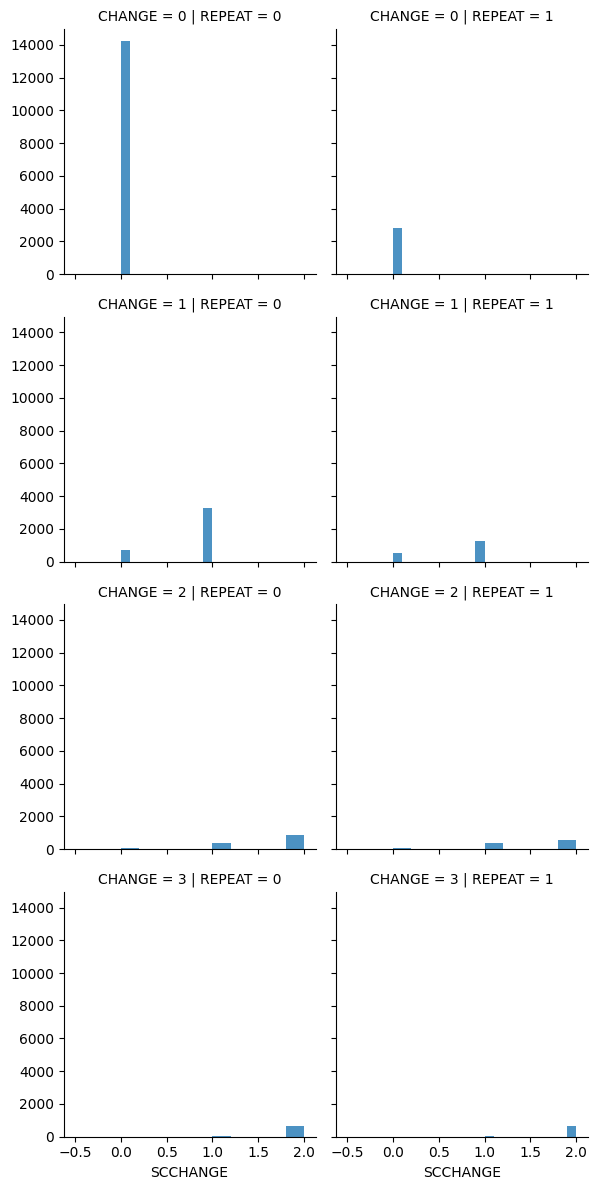

In [196]:
grid = sns.FacetGrid(dataset_school, row='CHANGE', col='REPEAT')
grid.map(plt.hist, 'SCCHANGE', alpha=.8, )
grid.add_legend()

同理，我们进行逻辑回归预测，由于原始字段均为离散的，因此不需要再进行分段处理。

我们看到，该特征组合"转校情况组合"对于是否复读的预测效果好于利用"学习能力组合"。

In [197]:
dataset_school=dataset_school.dropna(axis=0,how='any')
answer=dataset_school['REPEAT']
data=dataset_school.drop(['REPEAT'],axis=1)
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data, answer, test_size=0.2, random_state=0)
Y_train=Y_train.astype('int'); Y_test=Y_test.astype('int')
X_train.shape,X_test.shape,Y_train.shape, Y_test.shape

((21294, 4), (5324, 4), (21294,), (5324,))

In [198]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
try:
  logreg.fit(X_train, Y_train)
  Y_pred = logreg.predict(X_test)
finally:
  pass
acc_log = round(logreg.score(X_train, Y_train) , 4)
f1=round(f1_score(Y_test,Y_pred,average='macro'),4) # type: ignore
print("ACC:",acc_log,"F1:",f1)

ACC: 0.7616 F1: 0.5376


## 实验总结

PISA2018 包含了学生问卷，考试诊断，学校、老师等数个数据集。本次实验针对PICA2015中的学生调查问卷数据集，共490个特征。
- 大部分特征字段为具体的问卷调查回答，具体的考试题目得分；
- 学生概括性特征，包含性别，年龄，国籍，移民身份，所在年级等；
- 学生的学习水平特征，包括：具体科目的时间花费，抽象的个人学习能力等；
- 学生的家庭状况特征，包括：家庭资产水平，家庭中的文化相关资产水平，学生可使用电子设备的情况等；
- 学生父母相关特征，包括父母的受教育水平，父母的职业等；
- 一些和该调研本身相关的特征，例如问卷的语言选择代号，该学生是否接受过其他项目等；

与`REPEAT`字段强相关的特征：
- 学生所在年级与理应所在年级的差值`GRADE`；
- 学生的移民身份`IMMIG`；
- 学生在学业上花费的时间`TMINS`;
- 学生的个人学习能力的各项指标`METASUM`;
- 转校次数和累计转校次数的差值`CHANGE`-`SCCHANGE`;

与`REPEAT`字段弱相关的特征：
- 年龄；（年龄的关联性显著弱于所在年级的关联性）
- 性别；（男女性别样本数量均匀分布，可以确定无关）
- 国籍；（由于本次抽取的样本中，不同国籍的样本占比差异过大，无法得出有效结论）